# Image Registration Notebook 1
#### For 2D images

More info of the code used here on: https://simpleitk.readthedocs.io/en/master/registrationOverview.html .  

Author: Luis de la O

Welcome to this notebook on image registration! In this assignment, we will be experimenting with basic functions for registration of two images.

First we will explore the most common transforms and parameters to register basic figures as squares.
On the second notebook,  we will use this functions on a real world data.

**Notebook 1** :  
In this notebook we will use several custom python modules, that have to be installed before we can use them.
This is done in the code cell below. Please execute it and wait a bit for the installation to complete

After executing the cell, you should see quite a bit of lines of output, ending with a message stating that the installations and imports were completed succesfully.

In [1]:
!pip install SimpleITK

import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Version >2 is necessary
print("SimpleITK Version:", sitk.Version())

SimpleITK Version: SimpleITK Version: 2.3.0 (ITK 5.3)
Compiled: Sep 12 2023 18:43:59



### Mounting google drive to the notebook
This Colab notebook runs on a virtual machine (VM), hosted in one of Google's datacenters. By itself, it does not have any data associated with it (other than the default required to run CoLab). In order to do our segmentation project, we have to give it access to the dataset.

The easiest way to do this is by mounting your google drive on the VM. That way, you will give the notebook access to the data stored in your drive, such that it can be used for training and evaluating the models.

The code cell below starts the authentication procedure to mount your google drive. Please execute it and follow the authentication link that will show up in the cell. This will give you an authorization code. Enter that code in designated field in the cell below and press Enter to complete the authentication.


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


**Run the following definitions cell. no need to edit it, during the assignment**

In [4]:
# @title
#Run the following cell, no need to edit it, during the assignment
#author Luis de la O

import SimpleITK as sitk
import numpy as np
import os
import math
from skimage.measure import regionprops,label
from skimage import filters


def getCenter(image):
    threshold_value = filters.threshold_otsu(image)
    labeled_foreground = (image > threshold_value).astype(int)
    properties = regionprops(labeled_foreground, image)
    center_of_mass = properties[0].centroid
    weighted_center_of_mass = properties[0].weighted_centroid
    return center_of_mass,weighted_center_of_mass


# Functions 2D Translation2D Euler2D Similarity2D ScaleTransform2D
# Functions 3D Translation3D Euler3D VersorRigid3D Similarity3D Scale3D
def transformation_fun_select(arg,image):
    if arg == "Euler2D":
        return sitk.Euler2DTransform()
    if arg == "Similarity2D":
        return sitk.Similarity2DTransform()
    if arg == "ScaleTransform2D":
        return sitk.ScaleTransform(2)
    if arg == "Translation3D":
        return sitk.TranslationTransform(3)
    if arg == "Euler3D":
        return sitk.Euler3DTransform()
    if arg == "Similarity3D":
        return sitk.Similarity3DTransform()
    if arg == "VersorRigid3D":
        return sitk.VersorRigid3DTransform()
    if arg == "Scale3D":
        return sitk.ScaleVersor3DTransform()


def tailor_registration(fixed_array,moving_array,transf_spec,center_spec,metric_spec,gradient_spec,shift_sepc,offset="Diff",iterations_spec=300,lr=1,minStep=.00001,gradientT=1e-7,convWinSize=10,convMinVal=1e-7,plot_bool=False):
    fixed_image = sitk.GetImageFromArray(fixed_array)
    moving_image = sitk.GetImageFromArray(moving_array)
    fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
    moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

    transf_fun = transformation_fun_select(transf_spec,moving_array)
    if center_spec == "Geometry":
        center_fun = sitk.CenteredTransformInitializerFilter.GEOMETRY
    elif center_spec == "Moments":
        center_fun = sitk.CenteredTransformInitializerFilter.MOMENTS
    else:
        center_fun = sitk.CenteredTransformInitializerFilter.GetName()
        print(center_fun)
    #INITIALIZE
    registration_method = sitk.ImageRegistrationMethod()
    if transf_spec != "Translation2D":
        initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, transf_fun, center_fun)
        registration_method.SetInitialTransform(initial_transform, inPlace=False)
    else:
        #For 1D translation w_center of fixed array worked as offset
        if offset == "Diff":
            centroid_fix, w_center_fix = getCenter(fixed_array)
            centr_mov, w_center_mov = getCenter(moving_array)
            centroid_difference = (w_center_fix[0] - w_center_mov[0], w_center_fix[1] - w_center_mov[1])
        elif offset == "Fix":
            centroid_fix, w_center_fix = getCenter(fixed_array)
            centroid_difference = w_center_fix
        elif offset == "Mov":
            centroid_fix, w_center_fix = getCenter(moving_array)
            centroid_difference = w_center_fix
        else:
            print("No Offset Selected")

        translation_transform = sitk.TranslationTransform(2,centroid_difference)
        rigid_transform = sitk.Euler2DTransform()
        rigid_transform.SetTranslation(translation_transform.GetOffset())
        registration_method.SetInitialTransform(rigid_transform, inPlace=False)

    #METRICS
    if metric_spec == "Correlation":
        registration_method.SetMetricAsCorrelation()
    elif metric_spec == "MatesMutualInformation":
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
    elif metric_spec == "MeanSquares":
        registration_method.SetMetricAsMeanSquares()
    else:
        print("Error: No metric selected")
        exit(1)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.2)

    #OPTIMIZER
    if gradient_spec == "RegularStepGradientDescent":
        registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=lr, numberOfIterations=iterations_spec,minStep=minStep, gradientMagnitudeTolerance=gradientT)
    elif gradient_spec == "GradientDescent":
        registration_method.SetOptimizerAsGradientDescent(learningRate=lr, numberOfIterations=iterations_spec,convergenceMinimumValue=convMinVal,convergenceWindowSize=convWinSize)
    else:
        print("Error: No metric selected")
        exit(1)

    if shift_sepc == "PhysicalShift":
        registration_method.SetOptimizerScalesFromPhysicalShift()
    elif shift_sepc == "IndexShift":
        registration_method.SetOptimizerScalesFromIndexShift()
    else:
        print("Error: No metric selected")
        exit(1)

    #Registration
    final_transform = registration_method.Execute(fixed_image, moving_image)
    evaluationMetric = registration_method.GetMetricValue()
    initial_metric_value = registration_method.MetricEvaluate(fixed_image, moving_image)
    print(f"Initial metric value: {initial_metric_value}")
    print(f"Final metric value: {evaluationMetric}")
    print(f"Optimizer's stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
    moved_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    moved_array = sitk.GetArrayFromImage(moved_image)

    return moved_array,evaluationMetric,final_transform

The data on your google drive is now available to the notebook in the folder '/gdrive'. You can use the file explorer in the menu bar on the left or right side of the screen (click on the folder icon) to explore the file structure.

Once you've opened the file explorer, *you should see only two icons: one folder titled '..' and one titled 'sample_data'.* **Click on the '..' folder**, this will take you to the root directory. In here, look for the 'gdrive' folder and expand it to inspect the content. It probably contains another folder called 'My Drive'. This directory should show the files and folders on your google drive.

**NOTE**: The default working directory in colab is the '/content' folder. If you expand that one, you should see the 'sample_data' directory again.

**NOTE2**: At the top menu of the file explorer, there is an icon with the google drive logo on it. Do not click this! This is not a shortcut to your gdrive folder, but will attempt to remount your google drive, breaking it in the process.

## Load your database as ndarray and display it
Edit the root variable if neccesary to where your data is stored.
Noticed that inside the folder there are 9 squares. Each of them has a different number.
We assume that Square1 will be our fixed image and the rest of them (from 2 to 9) will be moving images that needs to be registered.   
Each Square has a different disruption, in the cell bellow you can also see it.

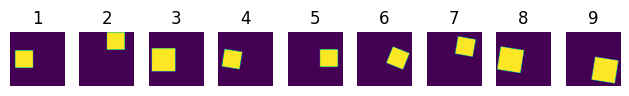

Sq1:Fixed image, Sq2:Translation 2D, Sq3:Isometric scaling, Sq4:Rotation, Sq5:Translation 1D
Sq6:Tanslation1D + Rotation, Sq7:Translation 2D + Rotation, Sq8:scaling +Rotation, Sq9:Rotation + Scaling + Translation


In [6]:
root = "/gdrive/My Drive/ImageRegistration/RegistrationPart1/Dataset1_Squares/"
sqs = ["Square1.jpg","Square2.jpg","Square3.jpg","Square4.jpg","Square5.jpg","Square6.jpg","Square7.jpg","Square8.jpg","Square9.jpg"]
for i in range(len(sqs)):
    image_sitk = sitk.ReadImage(root+sqs[i], sitk.sitkFloat32)
    image_array = sitk.GetArrayFromImage(image_sitk)
    plt.subplot(1,9,i+1),plt.imshow(image_array),plt.axis('off')
    plt.title(i+1)

plt.tight_layout()
plt.show()

print("Sq1:Fixed image, Sq2:Translation 2D, Sq3:Isometric scaling, Sq4:Rotation, Sq5:Translation 1D")
print("Sq6:Tanslation1D + Rotation, Sq7:Translation 2D + Rotation, Sq8:scaling +Rotation, Sq9:Rotation + Scaling + Translation")

To explain this notebook, we assume Square 1 is the fixed image and Square 3 will be our moving image.

Now we are going to load them as image them with the library SimpleITK, and also show them for you to inspect more in detail.

Image dimensions: Fixed Image:  (512, 512)  Moving Image: (512, 512)


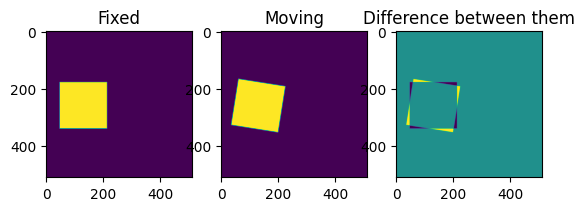

In [7]:
#Select
fixed_image_path = root+"Square1.jpg"
moving_image_path = root+"Square4.jpg" #When selecting other images mantain the format Square.jpg

#Load
fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
fixed_array = sitk.GetArrayFromImage(fixed_image)
moving_array = sitk.GetArrayFromImage(moving_image)

#Visualize both of your images, notice the difference between them
print("Image dimensions: Fixed Image: ",fixed_array.shape," Moving Image:", moving_array.shape)
plt.subplot(131),plt.imshow(fixed_array),plt.title('Fixed')
plt.subplot(132),plt.imshow(moving_array),plt.title('Moving')
plt.subplot(133),plt.imshow(moving_array-fixed_array),plt.title('Difference between them')
plt.show()

In [8]:
#We can also do a simple substraction to check how many pixels are out of place:
print("Number of pixels that are out of place: ",np.sum(abs(moving_array-fixed_array)))
print("Percentage of pixels that are out of place: ",100*np.sum(abs(moving_array-fixed_array))/np.sum(moving_array+fixed_array))

Number of pixels that are out of place:  936448.0
Percentage of pixels that are out of place:  6.765710903651505


**To Register them**: we can choose a 5 editable functions:  
1.-Transformation function.  
2.-Specific init center.  
3.- Metric function.  
4.- Optimizer function.  
5.- Shift (Real values or pixel values).  

###### Possible values are:  
-- **2D Transforms:** Euler2D. Similarity2D. ScaleTransform2D. Translation2D.  
-- **Center Spec:** Geometry . Moments.  
-- **Metrics:** Correlation . MatesMutualInformation. MeanSquares.  
-- **Optimizer:** GradientDescent . RegularStepGradientDescent.  
-- **Shift:** IndexShift . PhysicalShift

###### Other configurations editable with current defaults:  
**For TranslationTransform:** offset="Diff" or "Fix" or "Mov".
"Diff" is difference between centroids of moving and target. "Fixed" is centroid of Fixed. "Mov" is centroid of Moving.  

**For Optimizers** : .   
iterations_spec=300  . Maximum number of iteration for all Optimizers.  
lr=1  Learning Rate for all Optimizers.  
minStep=.00001  , Minimum Step for Optimizer: Regular Step Gradient Descent.  
gradientT=1e-7  , GradientMagnitudeTolerance for Optimizer :  Regular Step Gradient Descent.  
convWinSize=200  , Convergence Minimum Value for Optimizer: Gradient Descent.  
convMinVal=1e-6 , Convergence Window Size for Optimizer: : Gradient Descent.  

![Screenshot%20from%202023-09-21%2011-53-32.png](attachment:Screenshot%20from%202023-09-21%2011-53-32.png)

In [9]:
transf_spec = "Euler2D" #Euler2D. Similarity2D. ScaleTransform2D. Translation2D.
center_spec = "Geometry"  # Geometry or Moments
metric_spec = "Correlation"  # "Correlation" or "MatesMutualInformation" or "MeanSquares"
optimizer = "GradientDescent"  # GradientDescent" or "RegularStepGradientDescent"
shift_sepc = "IndexShift"  # "PhysicalShift" or "IndexShift"

#Both Optimizers
iterations_spec=80
lr=1
#ResgularStep Gradient
minStep=1e-7
gradientT=1e-8
#Gradient Descent
convMinVal =1e-6
convWinSize = 200
#Offset
offset = "Diff" #Fix, Mov, Diff

moved_array, evaluationMetric, final_transform = tailor_registration(fixed_array, moving_array, transf_spec,
                                                                         center_spec, metric_spec, optimizer,
                                                                         shift_sepc, offset, iterations_spec=iterations_spec,
                                                                         lr=lr,minStep=minStep, gradientT=gradientT,
                                                                         convMinVal=convMinVal,convWinSize = convWinSize)

Initial metric value: -0.8604127768924379
Final metric value: -0.9892952666636873
Optimizer's stopping condition: GradientDescentOptimizerv4Template: Maximum number of iterations (80) exceeded.


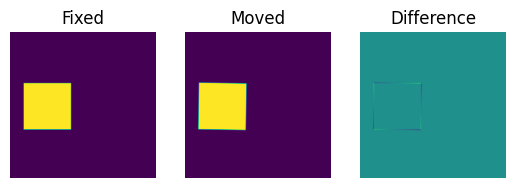

Number of pixels that are out of place:  134309.9
Percentage of pixels that are out of place:  0.970370875776402


In [10]:
#Visually see the registration:
plt.subplot(131),plt.imshow(fixed_array),plt.title('Fixed'),plt.axis('off')
plt.subplot(132),plt.imshow(moved_array),plt.title('Moved'),plt.axis('off')
plt.subplot(133),plt.imshow(fixed_array-moved_array),plt.title('Difference'),plt.axis('off')
plt.show()

#We can also do a simple substraction to check how many pixels are out of place:
print("Number of pixels that are out of place: ",np.sum(abs(moved_array-fixed_array)))
print("Percentage of pixels that are out of place: ",100*np.sum(abs(moved_array-fixed_array))/np.sum(moved_array+fixed_array))


# Assignment

As you have probably noticed, the visualization image and percent of pipxels out of place have improved a lot. This is because we have identified that the issue was with a rotation and therefore used an Euler2D Transform. **The task you have in this assignment is to register all the squares, by analizyng what kind of disruption does the moving image has compared to the fixed image. Once select the proper functions and parameters to perform the best possible registration.** For this application, a good registration usually has less than 5% of pixels out of place.

To complete the assignment, you have to write a *brief* report. Make sure to document:

1.   Which functions you use for each square. Include the parameters.
2.   What are the percentages of pixels out of place before and after registration
3.   Visualization on how the Square was before and after the registration.

The report can be brief, just write what you did and why. An introduction, references, etc. are not necessary. You can copy/screenshot all graphs/images from this notebook to illustrate your findings.


---

Parameter interpretation**

The parameters you can change are:

*   Number of Iterations
*   Learning rate
*   For Regular Step Gradient - Minimum Step (minStep), Gradient Tolerance (gradientT)
*   For Gradient Descent - Convergence Minimum Value (convMinVal), Convergence WindowSize (convWinSize)
*   Offset - For Translation Transforms Only - The offset can be the position of the either the fixed or moving image or the difference between its positions.

### Have some extra time and would like to test these methods on *medical* data?
Click the link to go to a new notebook and test this registration methods on real CT and CBCT patient data

Link: https://colab.research.google.com/drive/1hobFy8bYZSIBoghlUisxRBd8S4W3IAOG?authuser=1
